# 라이브러리 로드

In [5]:
import pandas as pd
import pandas.io.sql as psql
import psycopg2
import key
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns


plt.rc('font', family='Malgun Gothic')

plt.style.use('ggplot')
warnings.filterwarnings('ignore')

# 데이터 로드

In [6]:
HOST = key.host
DATABASE = key.database
USER = key.user
PASSWORD = key.password
conn= psycopg2.connect(host=HOST, database=DATABASE, user=USER, password=PASSWORD)
sql = "SELECT * FROM job"
df = psql.read_sql(sql, conn)
df.head()

,job_type,industry_code,industry_name,job_mid_code,job_mid_name,experience_code,experience_min,experience_max,education_code,salary_code,salary_info
0,정규직,209,가구·목재·제지,8,영업·판매·무역,0,0,0,0,99,면접후 결정
1,정규직,701,의료(진료과목별),6,의료,0,0,0,0,99,면접후 결정
2,정규직,702,의료(병원종류별),6,의료,0,0,0,0,99,면접후 결정
3,정규직,201,전기·전자·제어,11,생산,0,0,0,0,12,"3,000~3,200만원"
4,계약직,1005,연구소·컨설팅·조사,9,연구·R&D,0,0,0,5,17,"4,000~5,000만원"


# 사용하지 않을 데이터 제거

## 사용가능한 salary_info 추출

In [7]:
df.shape

(49610, 11)

In [8]:
df = df.loc[(df['salary_info'] != '면접후 결정') & (df['salary_info'] != '회사내규에 따름')]

In [9]:
df.shape

(12388, 11)

salary_info 컬럼을 확인해보니 '면접후 결정', '회사내규에 따름'과 같은  
명확한 연봉정보가 아닌 데이터가 있는것으로 확인하여 제거하였음

# 데이터 전처리

## 결측치 확인

In [10]:
df.isnull().sum()

job_type              0
industry_code         1
industry_name         1
job_mid_code          0
job_mid_name          0
experience_code       0
experience_min        0
experience_max        0
education_code        0
salary_code           0
salary_info        5663
dtype: int64

salary_info 컬럼에 5663개의 결측치가 존재하는 것으로 확인

In [11]:
df.loc[df['salary_info'].isnull()].head()

,job_type,industry_code,industry_name,job_mid_code,job_mid_name,experience_code,experience_min,experience_max,education_code,salary_code,salary_info
43,정규직,701,의료(진료과목별),6,의료,0,0,0,6,101,None
48,"파트,무기계약직,계약직,아르바이트",802,판매(상품품목별),10,서비스,3,1,0,0,104,None
51,아르바이트,1005,연구소·컨설팅·조사,9,연구·R&D,0,0,0,8,103,None
59,"계약직 (정규직 전환가능),계약직",202,기계·설비·자동차,11,생산,0,0,0,0,104,None
62,정규직,704,사회복지,20,공공·복지,3,1,3,7,101,None


salary_code를 확인해보면 101, 104등 잘못입력되어 보이는 값들이 확인되었음  
101는 11, 104는 14로 판단하고 그에 맞게 salary_info도 변경해주겠음

In [12]:
df['salary_code'].unique()

array(['12', '17', '14', '19', '10', '101', '104', '103', '9', '13', '8',
       '23', '11', '16', '21', '22', '18', '15', '20', '105', '98', '102'],
      dtype=object)

salary_code를 확인해보니 98의 값도 확인되었고 98의 값은 99로 판단하고 제거해주겠음

In [13]:
df['salary_info'].unique()

array(['3,000~3,200만원', '4,000~5,000만원', '3,400~3,600만원', '6,000~7,000만원',
       '2,600~2,800만원', None, '2,400~2,600만원', '3,200~3,400만원',
       '2,200~2,400만원', '1억원 이상', '2,800~3,000만원', '3,800~4,000만원',
       '8,000~9,000만원', '9,000~1억원', '5,000~6,000만원', '3,600~3,800만원',
       '7,000~8,000만원'], dtype=object)

In [14]:
df.loc[df['salary_code'] == "101","salary_info"] = '2,800~3,000만원'
df.loc[df['salary_code'] == "102","salary_info"] = '3,000~3,200만원'
df.loc[df['salary_code'] == "103","salary_info"] = '3,200~3,400만원'
df.loc[df['salary_code'] == '104',"salary_info"] = '3,400~3,600만원'
df.loc[df['salary_code'] == '105',"salary_info"] = '3,600~3,800만원'

남은 결측치는 모두 제거해줌

In [15]:
df = df.dropna()

## job_type 처리
job_type 컬럼은 현재 정규직, 계약직, 인턴직 등 여러 데이터들이  
list 형태로 되어있다. '정규직' 데이터 외의 데이터는 모두 계약직으로 판단하여 변경

In [16]:
job_type_index = df.loc[df['job_type'] != '정규직'].index

df.loc[job_type_index, "job_type"] = '계약직'

In [17]:
df['job_type'].unique()

array(['정규직', '계약직'], dtype=object)

## industry_code
industry_code는 사람인 open api의 코드표를 참고하여 변경하겠음
- industry_code 111이라고 가정하면 100으로 나누어 몫만 참고하여 1로 변경한 후에 코드표를 참고하여 서비스업으로 판단
- 같은 방식으로 1001일 경우 100으로 나누어 10으로 변경후에 코드표를 참고하여 기관,협회로 판단

In [18]:
df['industry_code'] = df['industry_code'].astype(int) // 100

# EDA

## 사용하지 않는 컬럼 제거

In [19]:
drop_columns = ['industry_name','job_mid_code','job_mid_name','experience_min','experience_max','salary_code']
df = df.drop(drop_columns, axis=1)

 그래프로 그리기 위하여 각 code컬럼들의 숫자들을 한글화 해주겠음

In [20]:
graph_df = df.copy()
graph_df = graph_df.reset_index(drop=True)

In [21]:
from app.dictionary_files import file
industry_dic = file.industry_dic
experience_dic = file.experience_dic
education_dic = file.education_dic
def change_industry(x):
  return industry_dic[str(x)]
def change_experience(x):
  return experience_dic[str(x)]
def change_education(x):
  return education_dic[str(x)]
graph_df['industry_code'] = graph_df['industry_code'].apply(change_industry)
graph_df['experience_code'] = graph_df['experience_code'].apply(change_experience)
graph_df['education_code'] = graph_df['education_code'].apply(change_education)
graph_df.head()

,job_type,industry_code,experience_code,education_code,salary_info
0,정규직,"제조,화학",경력무관,학력무관,"3,000~3,200만원"
1,계약직,"기관,협회",경력무관,박사졸업,"4,000~5,000만원"
2,정규직,"제조,화학",경력,"대학졸업(2,3년)","3,400~3,600만원"
3,정규직,건설업,경력,대학졸업(4년),"6,000~7,000만원"
4,정규직,건설업,경력무관,"대학졸업(2,3년)","3,400~3,600만원"


### 연봉의 분포 확인

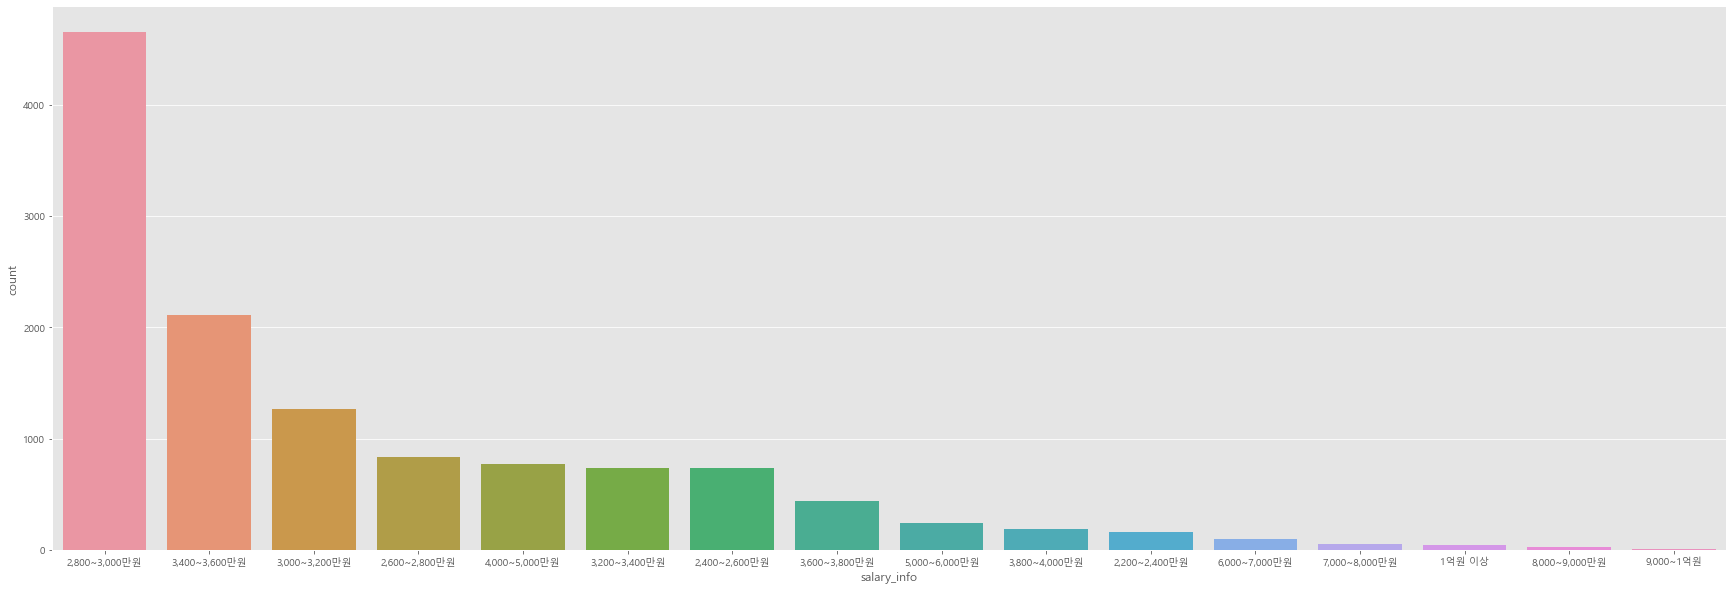

In [22]:
plt.figure(figsize=(30,10))
sns.countplot(data=graph_df, x='salary_info', order=graph_df['salary_info'].value_counts().index)
plt.show()

2,800~3000만원이 가장 많고, 3,400~3,600만원 순으로 분포가 나타남  
금액이 높아질수록 수가 낮아지는 것을 확인할 수 있음

### 근무형태의 분포

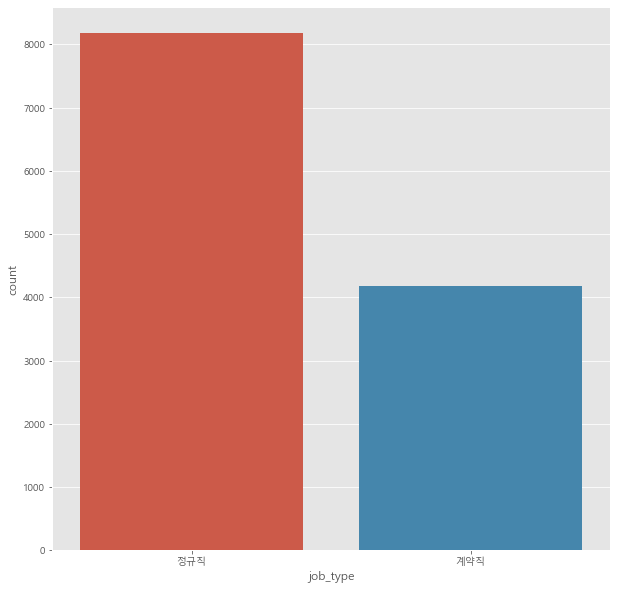

In [23]:
plt.figure(figsize=(10,10))
sns.countplot(data=graph_df, x='job_type')
plt.show()

#### 근무형태에 따른 연봉의 분포

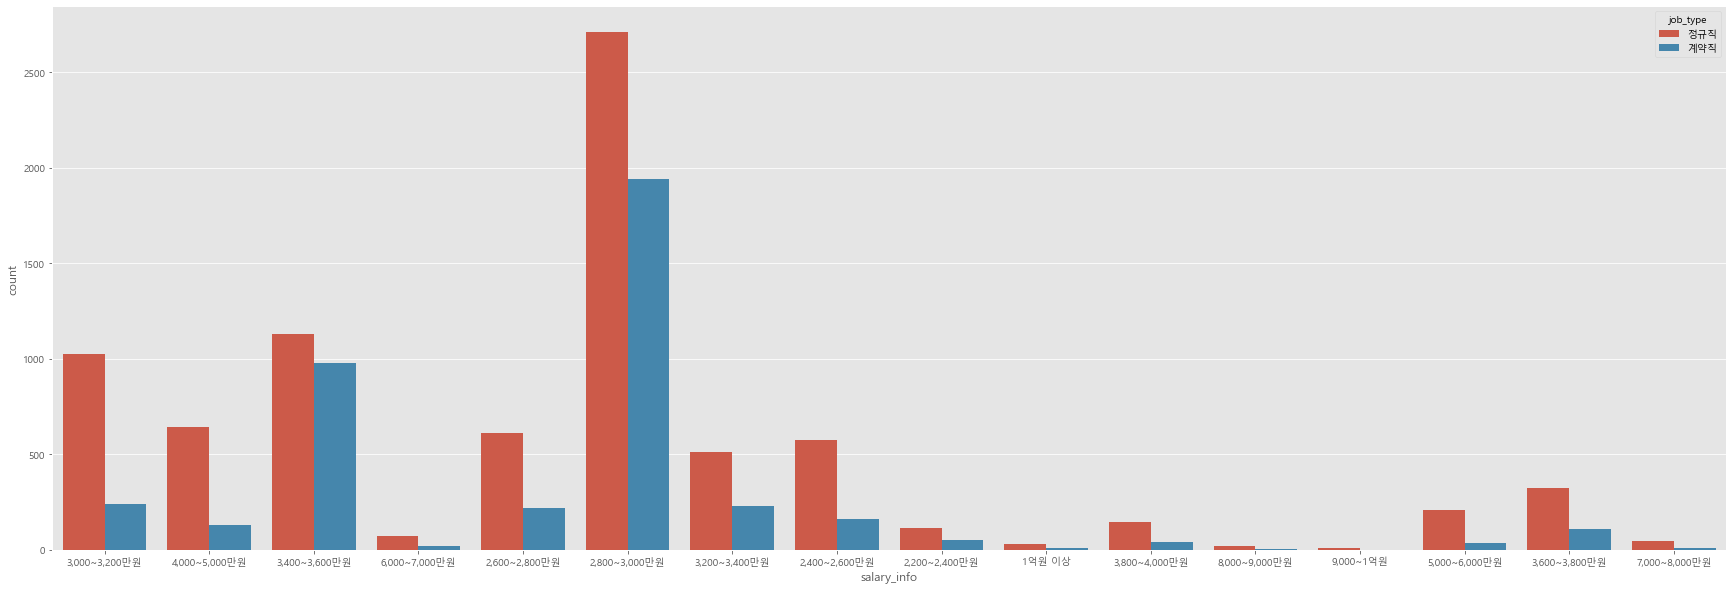

In [24]:
plt.figure(figsize=(30,10))
sns.countplot(data=graph_df, x='salary_info', hue='job_type')
plt.show()

3,000~3,200만원, 4,000~5,000만원 을 받는 근무형태가 정규직과 계약직의 차이가 크고,  
2,800~3,000만원, 3,400~3,600만원을 받는 근무형태 비교적 차이가 덜한것을 확인할 수 있음

### 산업 및 업종의 분포

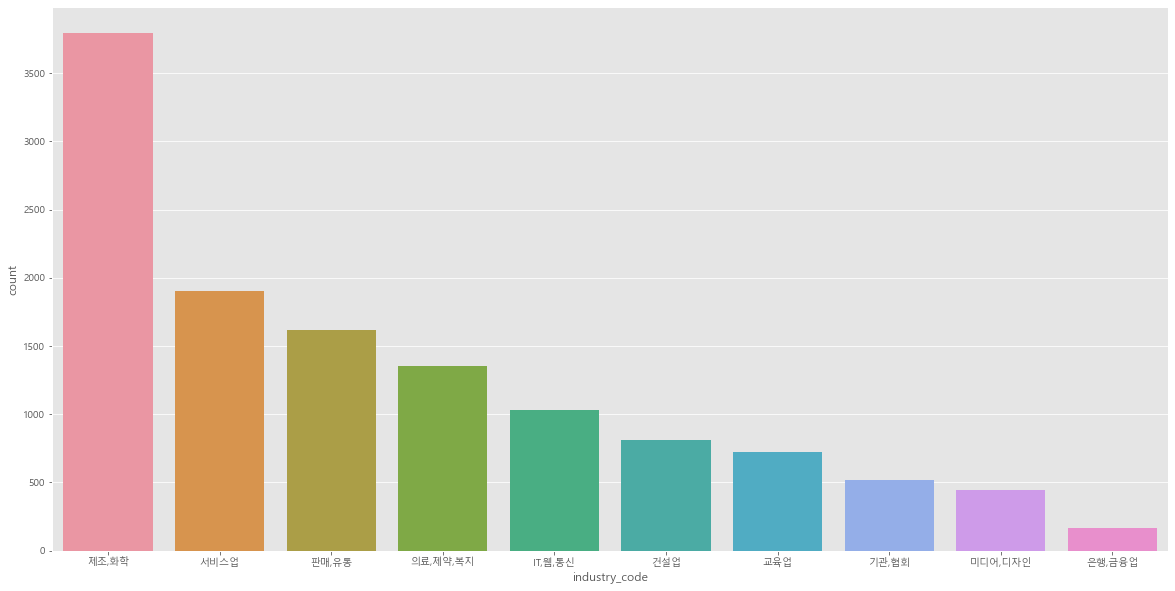

In [25]:
plt.figure(figsize=(20,10))
sns.countplot(data=graph_df, x='industry_code', order=graph_df['industry_code'].value_counts().index)
plt.show()

제조,화학, 서비스업, 판매유통 순으로 분포가 형성되어 있음

#### 산업 및 업종에 따른 연봉의 분포

In [26]:
# plt.figure(figsize=(20,10))
# sns.countplot(data=graph_df, x='industry_code', hue='salary_info')
# plt.show()

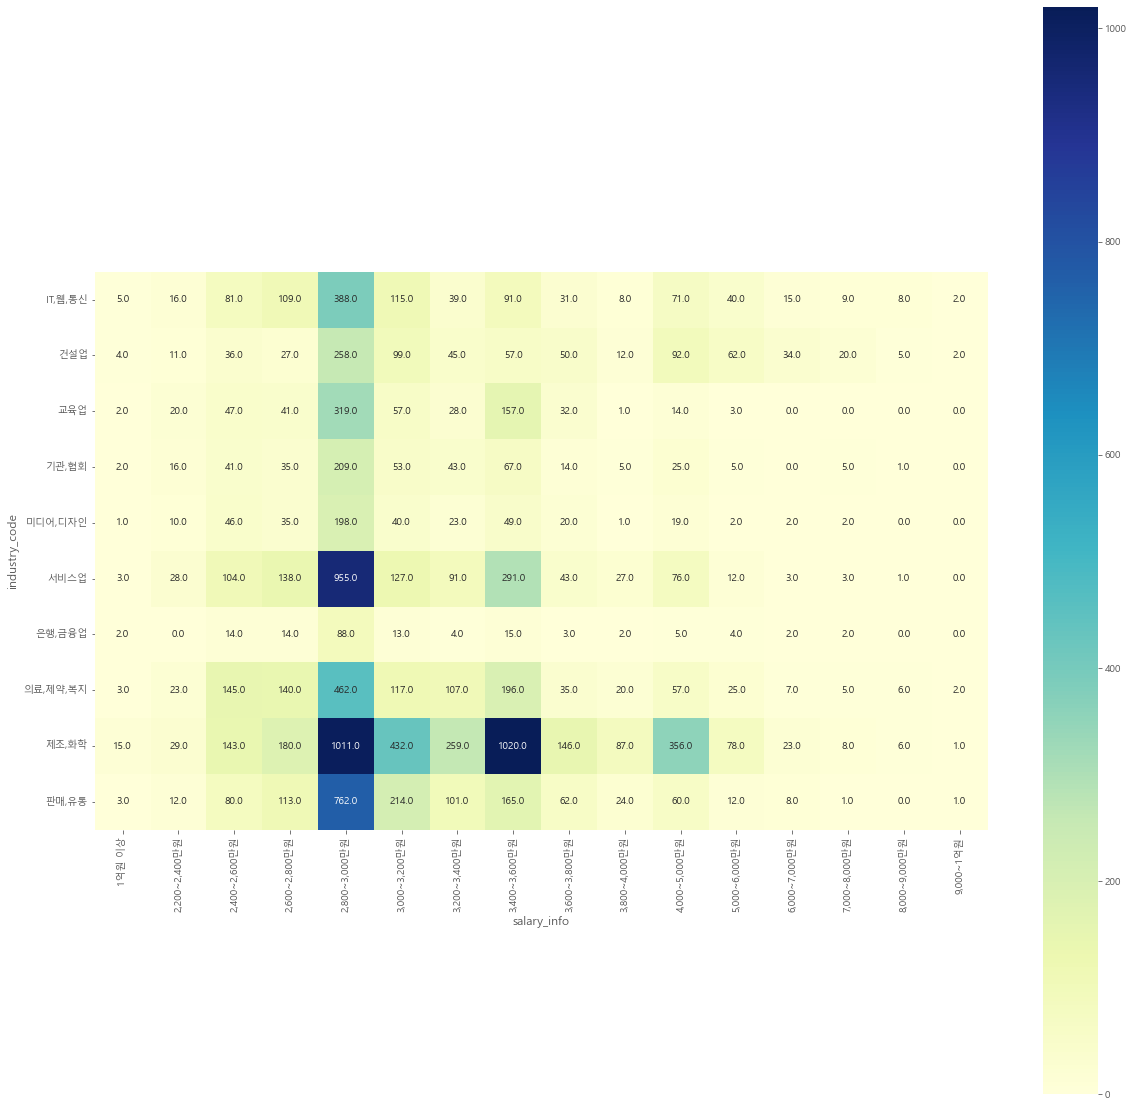

In [27]:
crosstab = pd.crosstab(graph_df['industry_code'], graph_df['salary_info'])
plt.figure(figsize=(20,20))
sns.heatmap(crosstab, square=True, annot=True, fmt='.1f', cmap="YlGnBu")
plt.show()

heatmap을 그려 확인해보니 제조화학 분야에서 2,800~3,000만원, 3,400~3800만원 경우가 가장 많은 것으로 확인.

### 경력의 분포

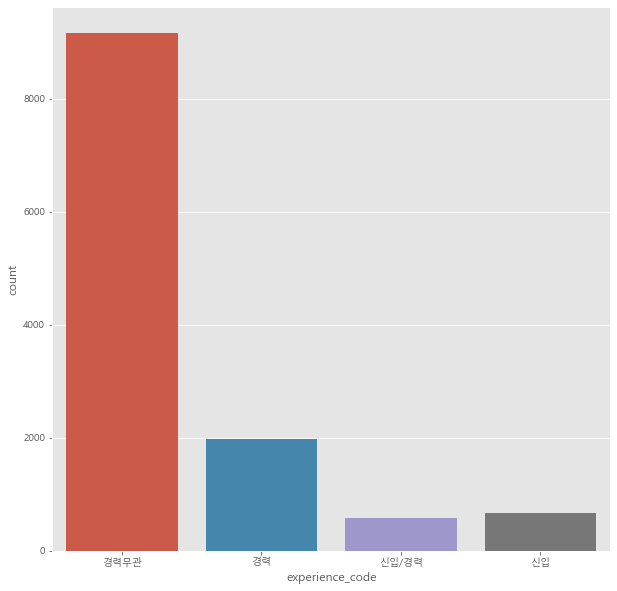

In [28]:
plt.figure(figsize=(10,10))
sns.countplot(data=graph_df, x='experience_code')
plt.show()

경력 무관을 뽑는 경우가 많았고, 경력, 신입 순으로 확인

#### 경력에 따른 연봉의 분포

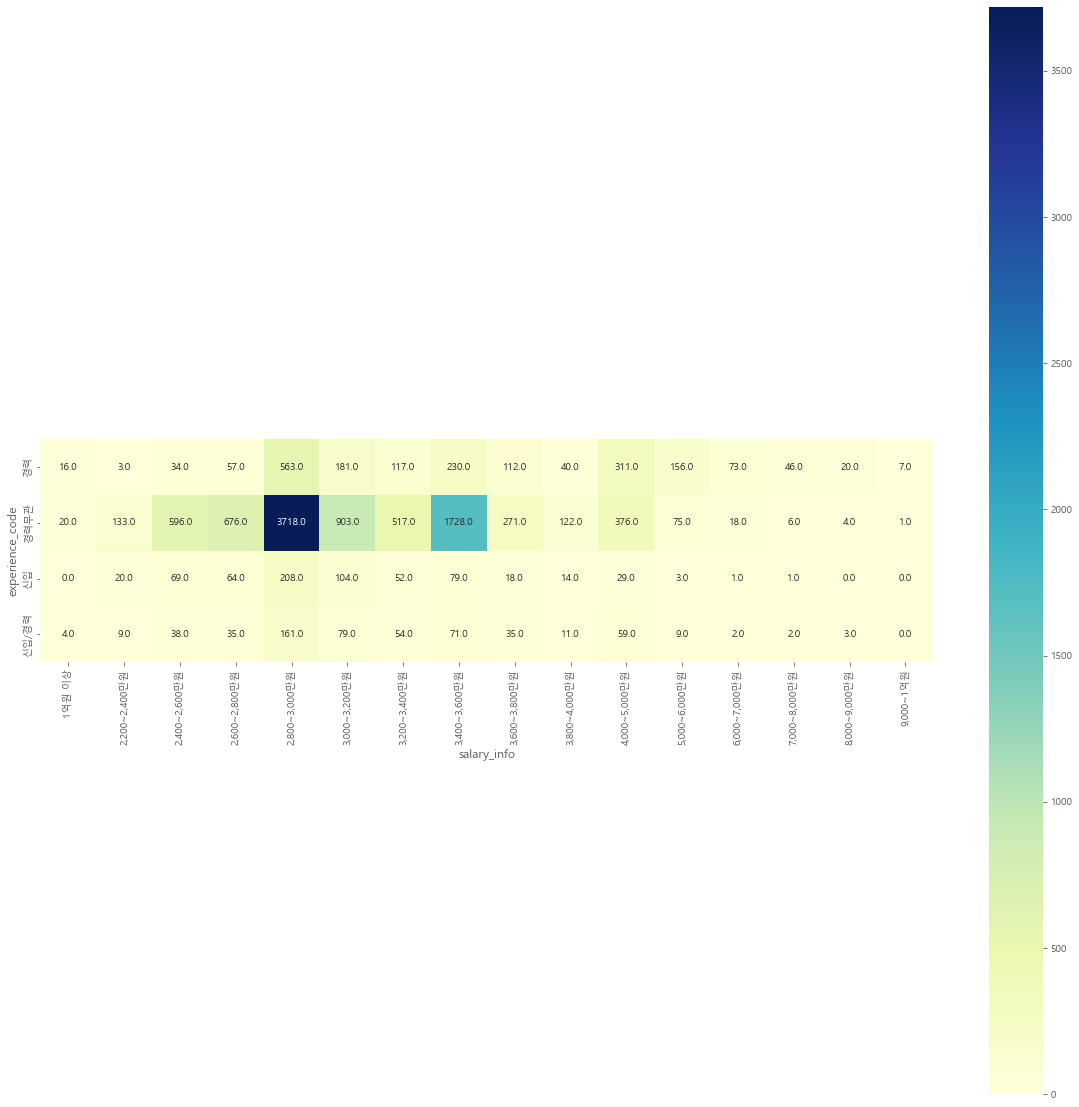

In [29]:
crosstab = pd.crosstab(graph_df['experience_code'], graph_df['salary_info'])
plt.figure(figsize=(20,20))
sns.heatmap(crosstab, square=True, annot=True, fmt='.1f', cmap="YlGnBu")
plt.show()

경력무관일때 2,800~3000만원, 3,400~3,600만원의 연봉을 주는 경우가 많음  
고연봉일수록 역시 경력직을 많이 주는것으로 확인

### 학력의 분포

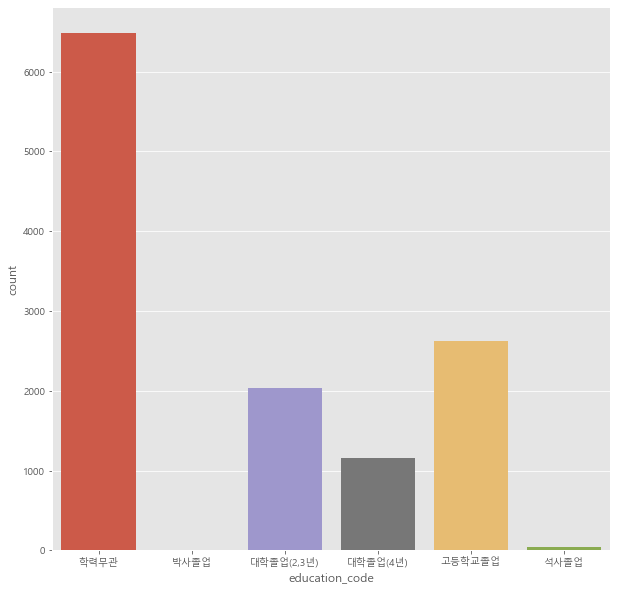

In [30]:
plt.figure(figsize=(10,10))
sns.countplot(data=graph_df, x='education_code')
plt.show()

학력무관, 고등학교졸업, 대학졸업(2,3년), 대학졸업(4년)순으로 뽑는경우가 많았음

#### 학력에 따른 연봉의 분포

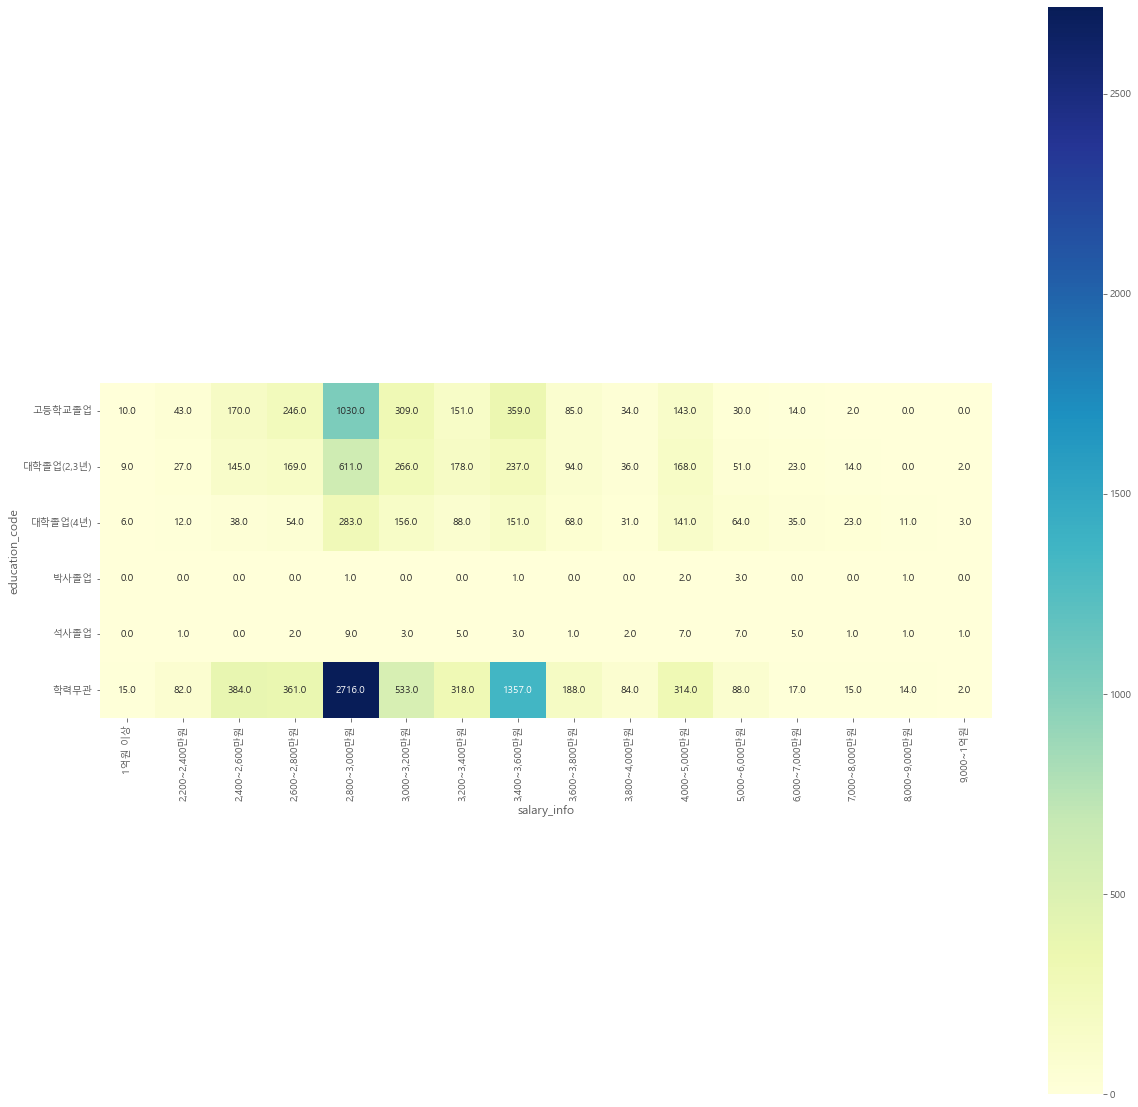

In [31]:
crosstab = pd.crosstab(graph_df['education_code'], graph_df['salary_info'])
plt.figure(figsize=(20,20))
sns.heatmap(crosstab, square=True, annot=True, fmt='.1f', cmap="YlGnBu")
plt.show()

학력무관일경우 2,800~3,000만원, 3,400~3,600만원의 연봉을 주는 경우가 많았고,  
석사, 박사 졸업은 표본이 부족하여 제대로 판단할 수 없음

In [51]:
graph_df.head()

,job_type,industry_code,experience_code,education_code,salary_info
0,정규직,"제조,화학",경력무관,학력무관,"3,000~3,200만원"
1,계약직,"기관,협회",경력무관,박사졸업,"4,000~5,000만원"
2,정규직,"제조,화학",경력,"대학졸업(2,3년)","3,400~3,600만원"
3,정규직,건설업,경력,대학졸업(4년),"6,000~7,000만원"
4,정규직,건설업,경력무관,"대학졸업(2,3년)","3,400~3,600만원"


In [53]:
#graph_df sql로 보내기
import sqlite3
conn = sqlite3.connect('eda.db')
graph_df.to_sql('job', conn)

12364

# 모델링
먼저 타겟데이터를 분리하고 데이터를 숫자형으로 변환해주겠음

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


In [34]:
y = df['salary_info']
X = df.drop('salary_info', axis=1)
X.shape, y.shape

((12364, 4), (12364,))

In [49]:
X.head()

,job_type,industry_code,experience_code,education_code
3,1,2,0,0
4,2,10,0,5
12,1,2,2,7
23,1,9,2,8
31,1,9,0,7


job_type 데이터를 1과 2로 변경을 해주고 모두 int형으로 바꾸어주겠음

In [35]:
def change_job_type(x):
  if x=='정규직':
    return 1
  else:
    return 2

X['job_type'] = X['job_type'].apply(change_job_type)

In [36]:
X = X.astype('int64')

데이터를 훈련데이터와 테스트데이터로 분리해주겠음

In [37]:
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, stratify=y)

print('훈련데이터 셋 : ', X_train.shape, y_train.shape)
print('테스트데이터 셋 : ', X_test.shape, y_test.shape)

훈련데이터 셋 :  (9891, 4) (9891,)
테스트데이터 셋 :  (2473, 4) (2473,)


In [38]:
rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

print(accuracy_score(y_test, pred))

0.3801051354630004


전반적인 accuracy가 0.38로 많이 낮은 것으로 확인  
기준모델로 설정하고 성능을 올려보겠음

In [39]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)

print(accuracy_score(y_test, pred))

[16:39:51] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.37970076829761423


In [40]:
light = LGBMClassifier()
light.fit(X_train, y_train)
pred = light.predict(X_test)

print(accuracy_score(y_test, pred))

0.38050950262838656


In [46]:
light = LGBMClassifier(random_state=42, n_esimators=1000)
params = {
  "max_depth" : np.arange(3, 10),
  "min_child_samples" : np.arange(10, 30),
  "learning_rate" : np.arange(0.01, 0.2, 0.01),
  "num_leaves" : np.arange(40, 60)
}
clf = RandomizedSearchCV(light, cv=5, param_distributions=params, scoring='accuracy',n_jobs=-1,random_state=42, n_iter=50)
clf.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: n_esimators


RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(n_esimators=1000, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]),
                                        'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'min_child_samples': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29]),
                                        'num_leaves': array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59])},
                   random_state=42, scoring='accuracy')

In [47]:
pred = clf.predict(X_test)
print(accuracy_score(y_test, pred))

0.38495754144763444


# 모델 피클링

In [48]:
import pickle
with open('model.pickle', 'wb') as pickle_file:
  pickle.dump(clf, pickle_file)